1. This program takes the combined trade and sentiments data as input:
a. aapl_trading_sentiment_data_all_days_chainofthought.csv and
b. aapl_trading_sentiment_data_all_days_RefPaper.csv
2. Sets up the stock trading environment using libraries from https://github.com/benstaf/FinRL_DeepSeek.git
3. Trains agents based on data from Chain of Thought prompting approach and the Reference Paper's prompting approach
4. Peforms back testing and evaluates both the trading agents
5. Compares the performance of the agents

In [ ]:
# Step 0: Prerequisites & Setup
# -------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')

!pip install finrl yfinance stockstats gymnasium stable_baselines3 alpaca-trade-api exchange_calendars wrds matplotlib pandas scikit-learn ta
%matplotlib inline

# Clone repo and set paths
!git clone https://github.com/benstaf/FinRL_DeepSeek.git
%cd /content/FinRL_DeepSeek
import sys
sys.path.append('/content/FinRL_DeepSeek')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'FinRL_DeepSeek' already exists and is not an empty directory.
/content/FinRL_DeepSeek


In [ ]:
# -------------------------------------------------
# Step 1: Data Loading and Preparation
# -------------------------------------------------
import pandas as pd
import numpy as np
from finrl.meta.preprocessor.preprocessors import data_split
import itertools

def load_and_prepare_data(filepath):
    """Load and prepare dataset for training"""
    df = pd.read_csv(filepath)
    df['date'] = pd.to_datetime(df['date']).dt.normalize()

    # Drop unwanted columns
    df = df.drop(columns=[col for col in df.columns if 'Unnamed:' in col or col.endswith('_y')])
    df.columns = [col.replace('_x', '') for col in df.columns]

    # Forward fill missing values
    list_ticker = df["tic"].unique().tolist()
    list_date = pd.date_range(start=df['date'].min(), end=df['date'].max())
    combination = list(itertools.product(list_date, list_ticker))

    processed_full = pd.DataFrame(combination, columns=["date", "tic"])
    processed_full['date'] = pd.to_datetime(processed_full['date']).dt.normalize()
    processed_full = processed_full.merge(df, on=["date", "tic"], how="left")
    processed_full = processed_full.sort_values(by=["tic", "date"]).ffill()

    return processed_full

# Load both datasets
chainofthought_df = load_and_prepare_data('/content/aapl_trading_sentiment_data_all_days_chainofthought.csv')
refpaper_df = load_and_prepare_data('/content/aapl_trading_sentiment_data_all_days_RefPaper.csv')

# Split into train/trade periods
TRAIN_START_DATE = '2022-06-03'
TRAIN_END_DATE = '2023-06-30'
TRADE_START_DATE = '2023-07-01'
TRADE_END_DATE = '2023-12-16'

def split_data(df):
    train_df = data_split(df, TRAIN_START_DATE, TRAIN_END_DATE)
    trade_df = data_split(df, TRADE_START_DATE, TRADE_END_DATE)
    return train_df, trade_df

chainofthought_train, chainofthought_trade = split_data(chainofthought_df)
refpaper_train, refpaper_trade = split_data(refpaper_df)

In [ ]:
# -------------------------------------------------
# Step 2: Environment Setup
# -------------------------------------------------
from env_stocktrading import StockTradingEnv
from finrl.config import INDICATORS
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import gymnasium as gym

def create_env(df, state_space=11):  # Correct observation space size
    """Create trading environment"""
    env = StockTradingEnv(
        df=df,
        stock_dim=1,
        num_stock_shares=[100],
        buy_cost_pct=[0.001],
        sell_cost_pct=[0.001],
        hmax=100,
        initial_amount=1_000_000,
        reward_scaling=1e-4,
        state_space=state_space,
        action_space=1,
        tech_indicator_list=INDICATORS,
        risk_indicator_col='sentiment'
    )
    print("lenght of INDICATORS" , len(INDICATORS))
    return DummyVecEnv([lambda: env])

# Create environments with correct observation size
chainofthought_train_env = create_env(chainofthought_train)
refpaper_train_env = create_env(refpaper_train)

from finrl.config import INDICATORS
print(f"Number of indicators: {len(INDICATORS)}")  # e.g., 5
state_space_size=11
#state_space_sizeprint(f"State space size : {len(state_space_size)}")
#state_space_size = 4 (price) + 1 (holdings) + len(INDICATORS) + 1 #(sentiment if used)
#print(f"Calculated state space size: {state_space_size}")"""

lenght of INDICATORS 8
lenght of INDICATORS 8
Number of indicators: 8


In [ ]:
# -------------------------------------------------
# Step 3: Train Both Agents
# -------------------------------------------------
def train_agent(env, model_name="ppo", total_timesteps=10000):
    """Train a trading agent"""
    model = PPO(
        "MlpPolicy",
        env,
        verbose=1,
        policy_kwargs={
            "net_arch": [{"pi": [64, 64], "vf": [64, 64]}]
        }
    )
    model.learn(total_timesteps=total_timesteps)
    return model

print("Training CoT Shot Agent...")
chainofthought_model = train_agent(chainofthought_train_env)
chainofthought_model.save("/content/chainofthought_trading_model")

print("\nTraining RefPaper Agent...")
refpaper_model = train_agent(refpaper_train_env)
refpaper_model.save("/content/refpaper_trading_model")


Training CoT Shot Agent...
Using cpu device


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 817  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
day: 391, episode: 10
begin_total_asset: 1014342.96
end_total_asset: 1119278.09
total_reward: 104935.13
total_cost: 3619.15
total_trades: 381
Sharpe: 1.063
------------------------------------------
| time/                   |              |
|    fps                  | 648          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0047238814 |
|    clip_fraction        | 0.0634       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 0.24         |
|    n_updates            | 10  

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 636  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
day: 391, episode: 10
begin_total_asset: 1014342.96
end_total_asset: 1160217.78
total_reward: 145874.82
total_cost: 3699.79
total_trades: 384
Sharpe: 0.884
-----------------------------------------
| time/                   |             |
|    fps                  | 521         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.006092909 |
|    clip_fraction        | 0.0327      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0003      |
|    loss                 | 0.107       |
|    n_updates            | 10          |
|   

In [ ]:
# -------------------------------------------------
# Step 4: Backtesting and Evaluation
# -------------------------------------------------
def calculate_metrics(df_account_value):
    """Calculate performance metrics"""
    df_account_value['daily_return'] = df_account_value['account_value'].pct_change(fill_method=None)
    daily_returns = df_account_value['daily_return'].dropna()

    # Basic metrics
    total_return = df_account_value['account_value'].iloc[-1] / df_account_value['account_value'].iloc[0] - 1
    annual_return = np.mean(daily_returns) * 252
    annual_volatility = np.std(daily_returns) * np.sqrt(252)
    sharpe_ratio = annual_return / annual_volatility if annual_volatility != 0 else 0

    # Drawdown calculations
    cumulative_returns = (1 + daily_returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (peak - cumulative_returns) / peak
    max_drawdown = drawdown.max()

    # Win rate
    win_rate = (daily_returns > 0).mean()

    return {
        'Total Return': total_return,
        'Annual Return': annual_return,
        'Annual Volatility': annual_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Win Rate': win_rate
    }

def evaluate_agent(model, trade_df):
    """Evaluate agent performance"""
    env = StockTradingEnv(
        df=trade_df,
        stock_dim=1,
        num_stock_shares=[100],
        buy_cost_pct=[0.001],
        sell_cost_pct=[0.001],
        hmax=100,
        initial_amount=1_000_000,
        reward_scaling=1e-4,
        state_space=11,
        action_space=1,
        tech_indicator_list=INDICATORS,
        risk_indicator_col='sentiment'
    )

    obs, _ = env.reset()
    account_values = [env.initial_amount]
    dates = [trade_df.iloc[0]['date']]

    for i in range(len(trade_df)-1):
        action, _ = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # Get current account value directly from the environment
#        current_account_value = env.total_asset
# replaced from below line
# Get current account value from the info dict (fallback to internal memory)
        current_account_value = info.get('total_asset', None)
        if current_account_value is None:
# as a backup, grab the last recorded value
          current_account_value = env.asset_memory[-1]  # or env.state[0]
# replaced till above line
        account_values.append(current_account_value)
        dates.append(trade_df.iloc[i+1]['date'])

        if done:
            break

    df_account_value = pd.DataFrame({'date': dates, 'account_value': account_values})
    perf_metrics = calculate_metrics(df_account_value)

    return df_account_value, perf_metrics

print("\nEvaluating Chain of Thought Agent...")
cf_account_value, cf_metrics = evaluate_agent(chainofthought_model, chainofthought_trade)

print("\nEvaluating RefPaper Agent...")
rp_account_value, rp_metrics = evaluate_agent(refpaper_model, refpaper_trade)


Evaluating Chain of Thought Agent...

Evaluating RefPaper Agent...



=== Performance Comparison ===
           Metric  Chain of Thought  RefPaper
     Total Return          0.055854  0.019603
    Annual Return          0.083524  0.029524
Annual Volatility          0.054757  0.021384
     Sharpe Ratio          1.525363  1.380649
     Max Drawdown          0.036638  0.012251
         Win Rate          0.389222  0.395210


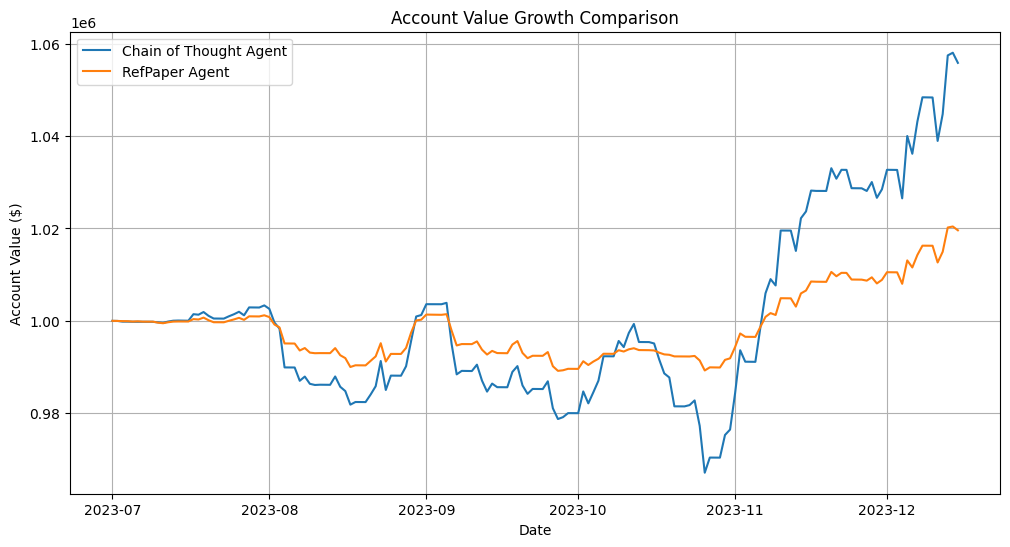

In [ ]:


# -------------------------------------------------
# Step 5: Comparison and Visualization
# -------------------------------------------------
import matplotlib.pyplot as plt

# Combine results for comparison
results_df = pd.DataFrame({
    'Metric': list(cf_metrics.keys()),
    'Chain of Thought': list(cf_metrics.values()),
    'RefPaper': list(rp_metrics.values())
})

print("\n=== Performance Comparison ===")
print(results_df.to_string(index=False))

# Plot account value growth
plt.figure(figsize=(12, 6))
plt.plot(cf_account_value['date'], cf_account_value['account_value'], label='Chain of Thought Agent')
plt.plot(rp_account_value['date'], rp_account_value['account_value'], label='RefPaper Agent')
plt.title('Account Value Growth Comparison')
plt.xlabel('Date')
plt.ylabel('Account Value ($)')
plt.legend()
plt.grid()
plt.show()